# MUMA LAB 3
Author: Marcin Poloczek

# Problem Description
Input variables:
- bank client data:
	- age (numeric)
	- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
	- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
	- education (categorical: "unknown","secondary","primary","tertiary")
	- default: has credit in default? (binary: "yes","no")
	- balance: average yearly balance, in euros (numeric) 
	- housing: has housing loan? (binary: "yes","no")
	- loan: has personal loan? (binary: "yes","no")
- related with the last contact of the current campaign:
	- contact: contact communication type (categorical: "unknown","telephone","cellular") 
	- day: last contact day of the month (numeric)
	- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
	- duration: last contact duration, in seconds (numeric)
- other attributes:
	- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
	- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
	- previous: number of contacts performed before this campaign and for this client (numeric)
	- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

- Output variable (desired target):
	- y - has the client subscribed a term deposit? (binary: "yes","no")


# Get the data

In [349]:
library(BCA);
library(car);
library(RcmdrMisc);
library(sandwich);
library(relimp);
library(corrplot);
library(tidyverse);
library(tidyr);
library(gridExtra);
library(caTools);
library(caret);

options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 150)

bank <- read_delim("data/bank-full.csv", delim = ";",
    col_types = "iffffdfffifiiiiff")

head(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no


In [350]:
bank <- bank %>%
    mutate(y = as.logical(y == "yes"))

In [351]:
summary(bank)

      age                 job           marital          education    
 Min.   :18.00   blue-collar:9732   married :27214   tertiary :13301  
 1st Qu.:33.00   management :9458   single  :12790   secondary:23202  
 Median :39.00   technician :7597   divorced: 5207   unknown  : 1857  
 Mean   :40.94   admin.     :5171                    primary  : 6851  
 3rd Qu.:48.00   services   :4154                                     
 Max.   :95.00   retired    :2264                                     
                 (Other)    :6835                                     
 default        balance       housing      loan            contact     
 no :44396   Min.   : -8019   yes:25130   no :37967   unknown  :13020  
 yes:  815   1st Qu.:    72   no :20081   yes: 7244   cellular :29285  
             Median :   448                           telephone: 2906  
             Mean   :  1362                                            
             3rd Qu.:  1428                                            


# Inspect the data

# Histogram of Age by Y

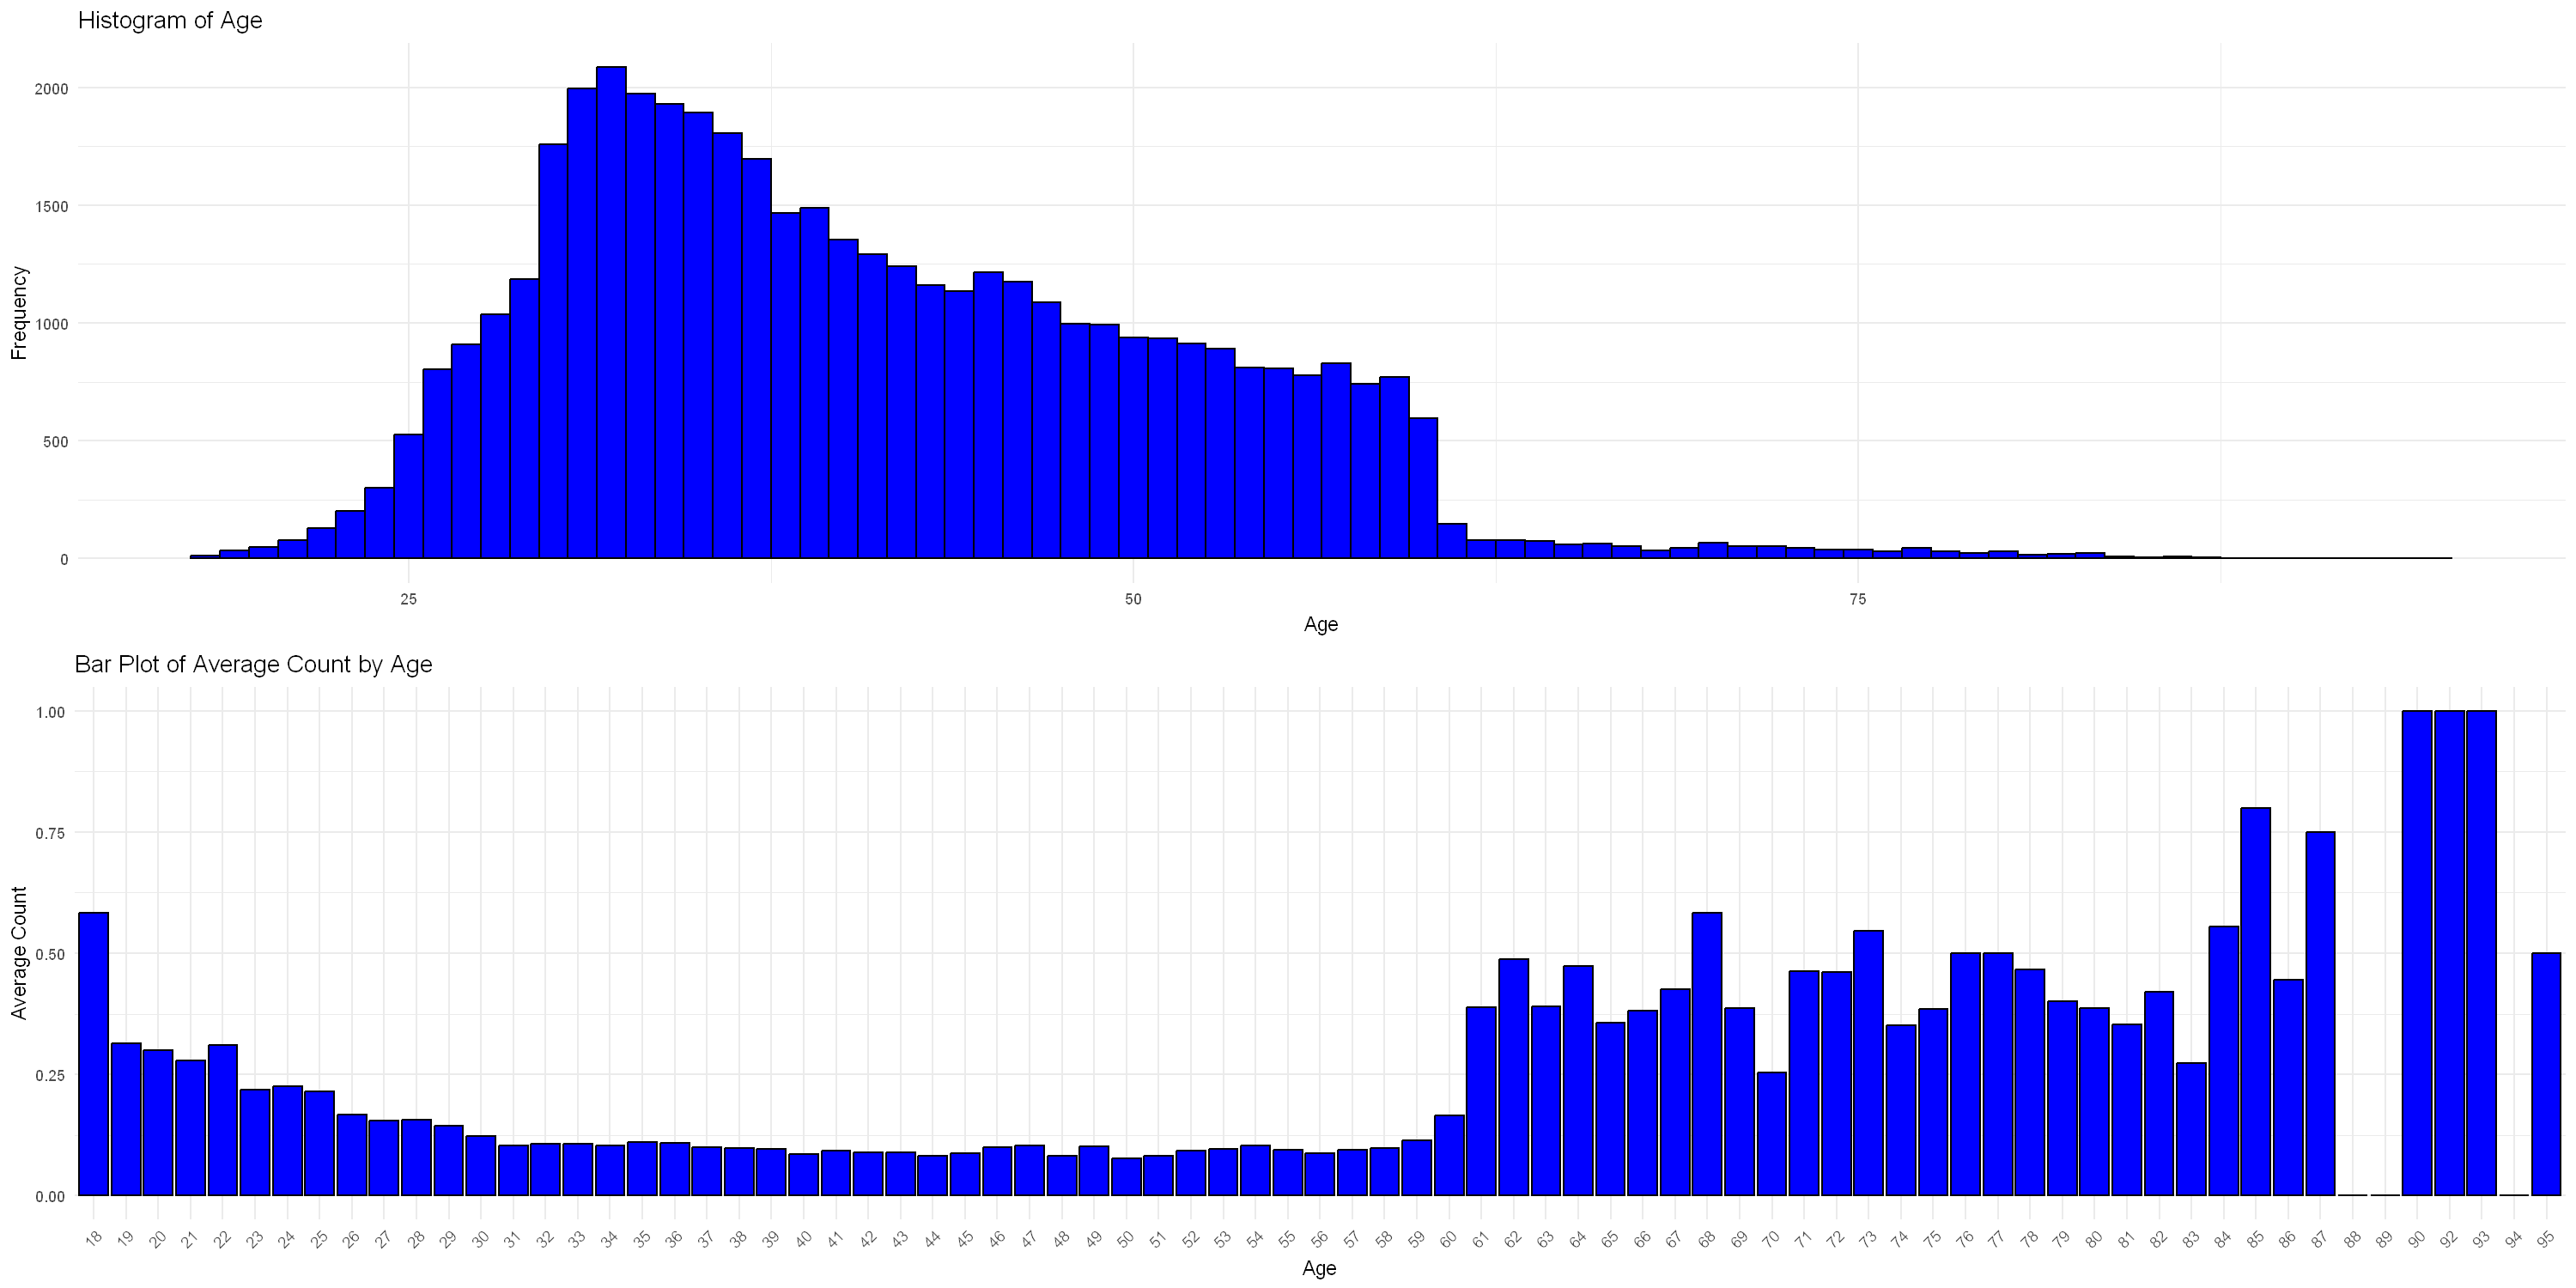

In [352]:
p0 <- bank %>% ggplot(aes(x = age)) +
    geom_histogram(binwidth = 1, fill = "blue", color = "black") + 
    labs(title = "Histogram of Age",
        x = "Age",
        y = "Frequency") +
    theme_minimal()

average_count <- aggregate(y ~ age, data = bank, FUN = mean)

p1 <- average_count %>% 
    ggplot(aes(x = factor(age), y = y)) +
    geom_bar(stat = "identity", fill = "blue", color = "black") +  # Use blue bars with black borders
    labs(title = "Bar Plot of Average Count by Age",
        x = "Age",
        y = "Average Count") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) 


grid.arrange(p0, p1, ncol=1, nrow = 2)

The upper diagram shows the frequency of records by age. The lower diagram shows the probability of a given age subscribing to the deposit. There is a trend on the lower diagram showing the elderly (60+ years) being more likely to subscribe to the deposit. This however might be explained by the under-representation of the data in those age categories. Most of the records are located between 20 and 60 years of age.

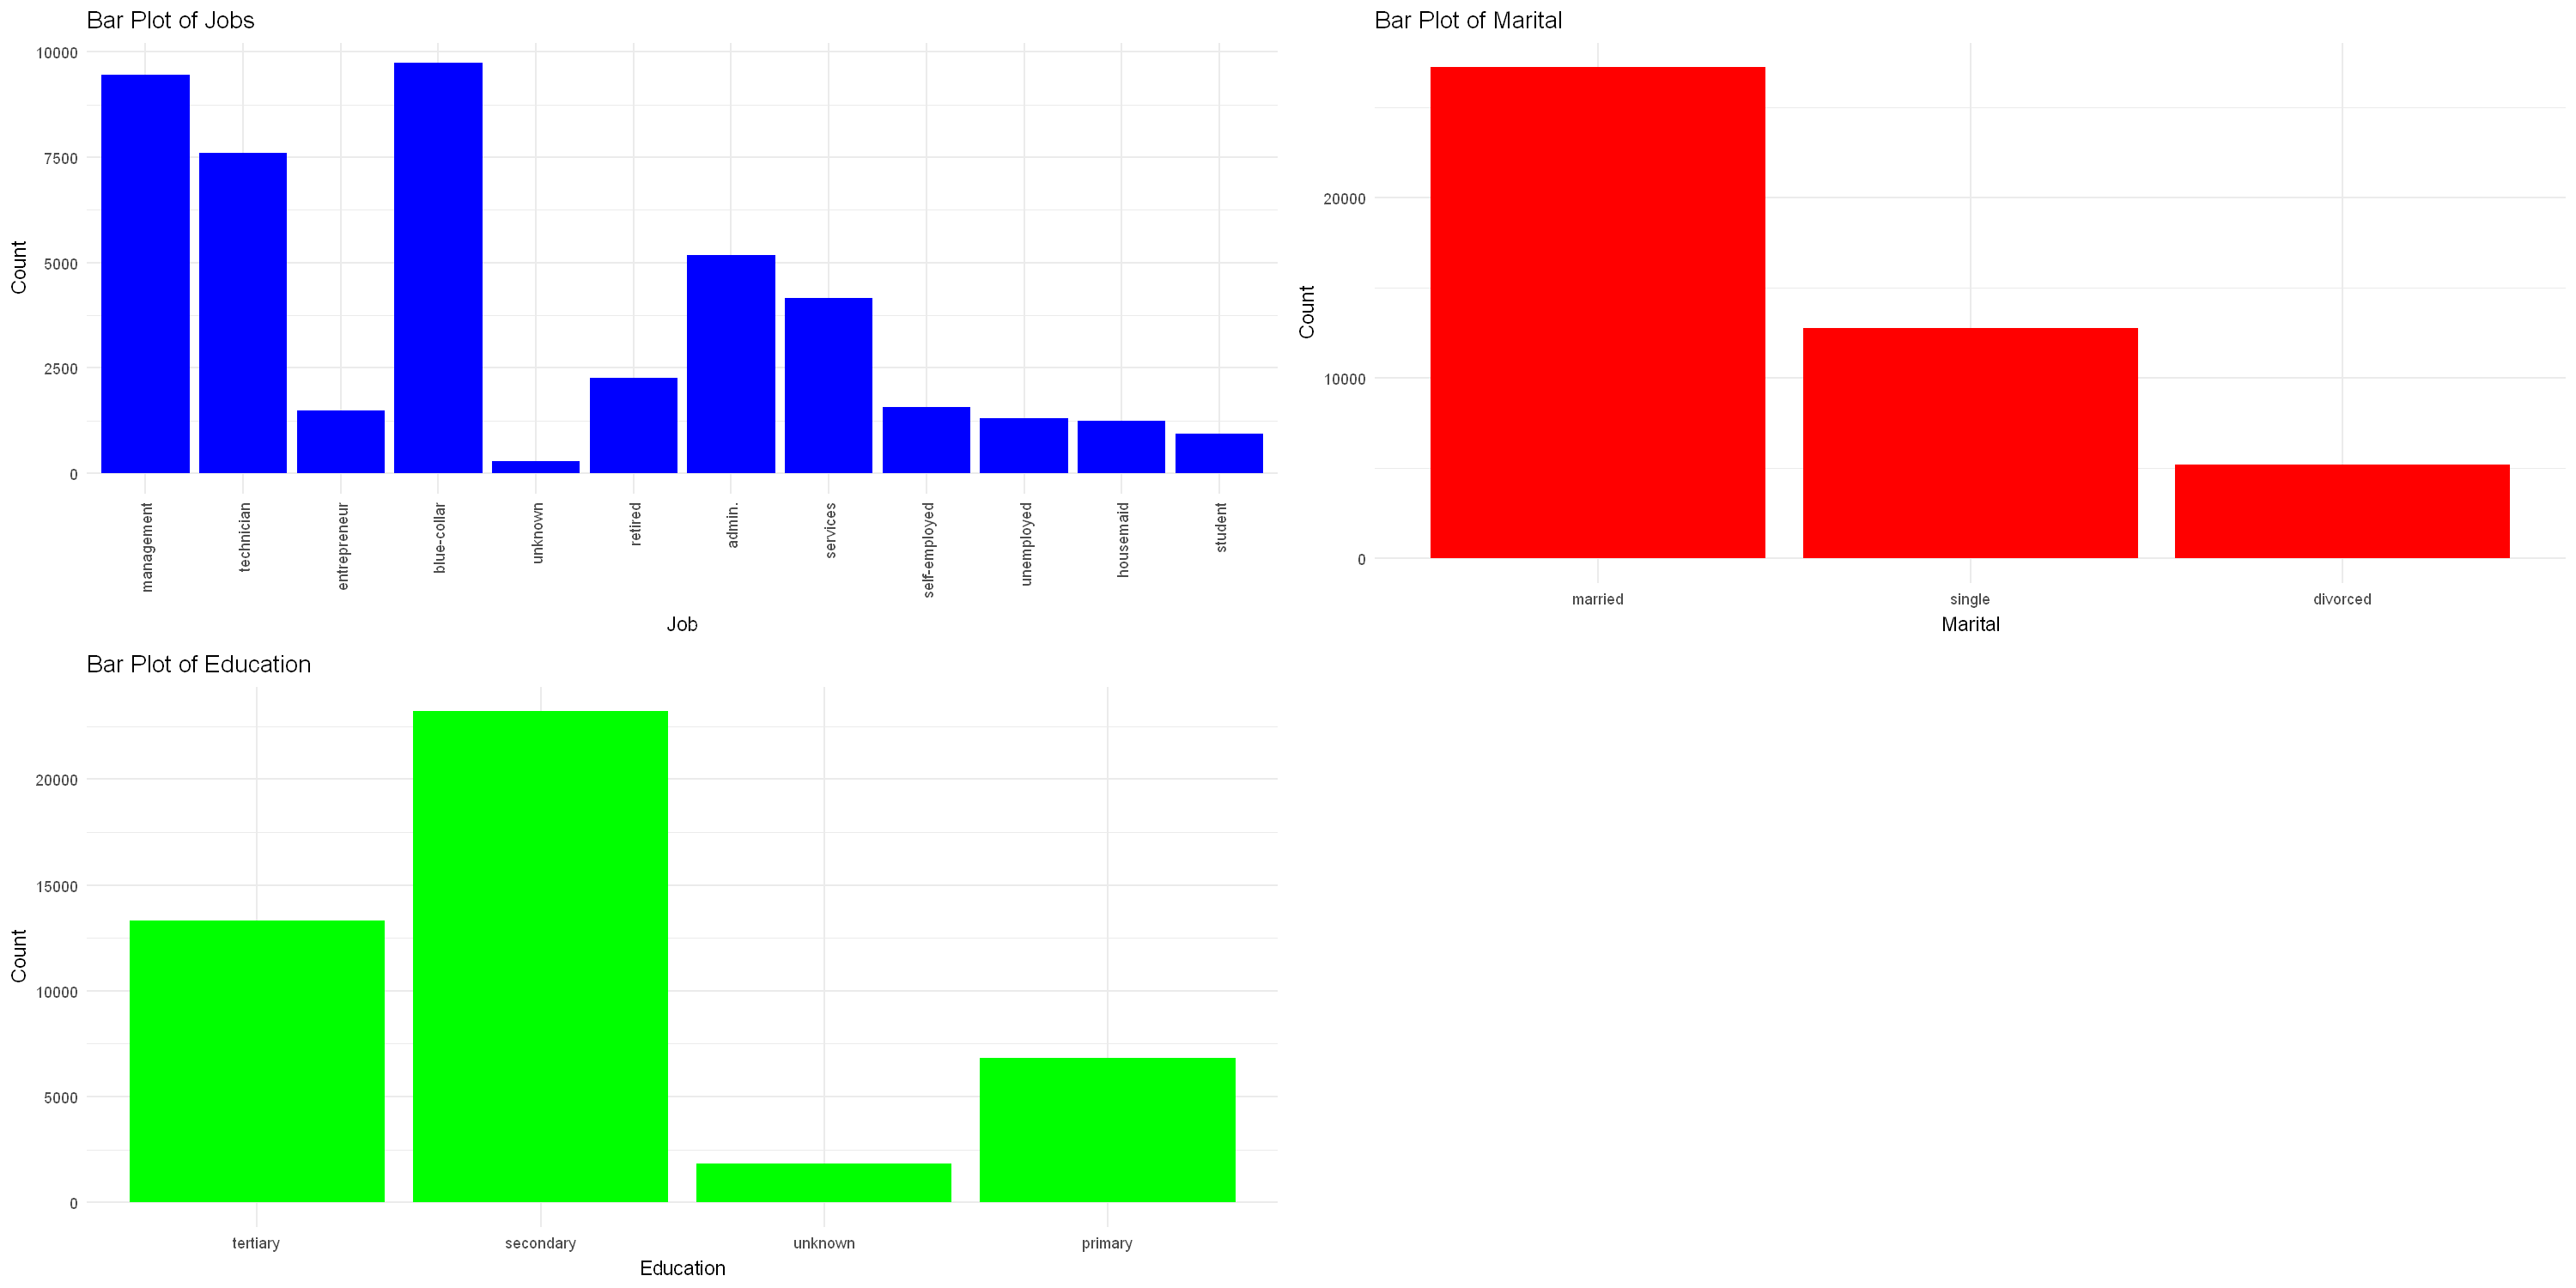

In [353]:
p0 <- bank %>%
    ggplot(aes(x = job)) +
    geom_bar(fill = "blue") +
    labs(title = "Bar Plot of Jobs",
        x = "Job",
        y = "Count") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

p1 <- bank %>%
    ggplot(aes(x = marital)) +
    geom_bar(fill = "red") +
    labs(title = "Bar Plot of Marital",
        x = "Marital",
        y = "Count") +
    theme_minimal()

p2 <- bank %>%
    ggplot(aes(x = education)) +
    geom_bar(fill = "green") +
    labs(title = "Bar Plot of Education",
        x = "Education",
        y = "Count") +
    theme_minimal()


grid.arrange(p0, p1, p2, ncol=2, nrow = 2)

Professions that are the most likely to subscribe to the term deposit are management, technicians, and blue-collar workers. 
Married people and those who have a secondary education are also more likely to make the deposit.

# Model

## Logarithmized values
Add 1 to values that contain zero.

In [354]:
bank <- bank %>%
    mutate(
        age_log = log(age),
        day_log = log(day),
        duration_log = log(duration + 1),
        campaign_log = log(campaign + 1),
        pdays_log = log(pdays + 2), # min value is -1
        previous_log = log(previous + 1)
    )

head(bank)

age,job,marital,education,default,balance,housing,loan,contact,day,⋯,pdays,previous,poutcome,y,age_log,day_log,duration_log,campaign_log,pdays_log,previous_log
<int>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<int>,⋯,<int>,<int>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,management,married,tertiary,no,2143,yes,no,unknown,5,⋯,-1,0,unknown,FALSE,4.060443,1.609438,5.568345,0.6931472,0,0
44,technician,single,secondary,no,29,yes,no,unknown,5,⋯,-1,0,unknown,FALSE,3.784190,1.609438,5.023881,0.6931472,0,0
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,⋯,-1,0,unknown,FALSE,3.496508,1.609438,4.343805,0.6931472,0,0
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,⋯,-1,0,unknown,FALSE,3.850148,1.609438,4.532599,0.6931472,0,0
33,unknown,single,unknown,no,1,no,no,unknown,5,⋯,-1,0,unknown,FALSE,3.496508,1.609438,5.293305,0.6931472,0,0
35,management,married,tertiary,no,231,yes,no,unknown,5,⋯,-1,0,unknown,FALSE,3.555348,1.609438,4.941642,0.6931472,0,0


## Creating train and test sets

In [355]:
set.seed(17)
train_test_set <- sample.split(bank$y, SplitRatio = 0.7)
bank_train <- subset(bank, train_test_set == TRUE)
bank_test <- subset(bank, train_test_set == FALSE)

nrow(bank_train)
nrow(bank_test)

[1] 31647

[1] 13564

## Model creation

In [356]:
mdl <- glm(y ~ age + job + marital + education + default + balance + housing + loan + contact + day + month + duration + campaign + pdays + previous + poutcome, 
    family = binomial(logit), data = bank_train)
summary_mdl <- summary(mdl)
summary_mdl


Call:
glm(formula = y ~ age + job + marital + education + default + 
    balance + housing + loan + contact + day + month + duration + 
    campaign + pdays + previous + poutcome, family = binomial(logit), 
    data = bank_train)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -5.320e+00  1.592e-01 -33.426  < 2e-16 ***
age                -3.734e-04  2.640e-03  -0.141 0.887495    
jobtechnician      -6.301e-02  7.671e-02  -0.821 0.411393    
jobentrepreneur    -1.195e-01  1.388e-01  -0.861 0.389343    
jobblue-collar     -1.677e-01  8.885e-02  -1.888 0.059068 .  
jobunknown         -2.554e-01  2.737e-01  -0.933 0.350778    
jobretired          4.590e-01  1.104e-01   4.159 3.19e-05 ***
jobadmin.           1.322e-01  8.826e-02   1.498 0.134238    
jobservices        -8.297e-02  1.025e-01  -0.810 0.418211    
jobself-employed   -2.077e-01  1.266e-01  -1.640 0.101020    
jobunemployed      -1.096e-01  1.297e-01  -0.845 0.397906    
jobhousema

In [357]:
ComputeMcFadden <- function(model) {
    return(1 - (model$deviance / model$null.deviance)) # McFadden R2
}

mdl %>% ComputeMcFadden()

[1] 0.3368891

In [358]:
anova_mdl <- as.data.frame(Anova(mdl)) %>% arrange(desc(`Pr(>Chisq)`))
anova_mdl

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
age,2.001825e-02,1,8.874861e-01
default,4.896218e-02,1,8.248791e-01
pdays,1.118031e-01,1,7.381006e-01
previous,1.223543e+00,1,2.686664e-01
balance,5.881658e+00,1,1.529941e-02
day,1.003472e+01,1,1.536170e-03
education,2.088320e+01,3,1.113226e-04
marital,2.421842e+01,2,5.508557e-06
loan,3.879842e+01,1,4.699077e-10


In [359]:
anova_mdl %>% filter(`Pr(>Chisq)` > 0.05)

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
age,0.02001825,1,0.8874861
default,0.04896218,1,0.8248791
pdays,0.11180306,1,0.7381006
previous,1.22354310,1,0.2686664


Variables `age`, `default`, `pdays` and `previous` can be removed.

In [360]:
bank_pred <- predict(mdl, newdata = bank_test, type = "response")
bank_pred <- as.logical(round(bank_pred))
accuracy <- mean(bank_pred == bank_test$y)
accuracy

[1] 0.9022412

In [361]:
confusion <- confusionMatrix(data = as.factor(bank_pred), reference = as.factor(bank_test$y))
confusion

Confusion Matrix and Statistics

          Reference
Prediction FALSE  TRUE
     FALSE 11694  1043
     TRUE    283   544
                                          
               Accuracy : 0.9022          
                 95% CI : (0.8971, 0.9072)
    No Information Rate : 0.883           
    P-Value [Acc > NIR] : 4.89e-13        
                                          
                  Kappa : 0.4028          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9764          
            Specificity : 0.3428          
         Pos Pred Value : 0.9181          
         Neg Pred Value : 0.6578          
             Prevalence : 0.8830          
         Detection Rate : 0.8621          
   Detection Prevalence : 0.9390          
      Balanced Accuracy : 0.6596          
                                          
       'Positive' Class : FALSE           
                  

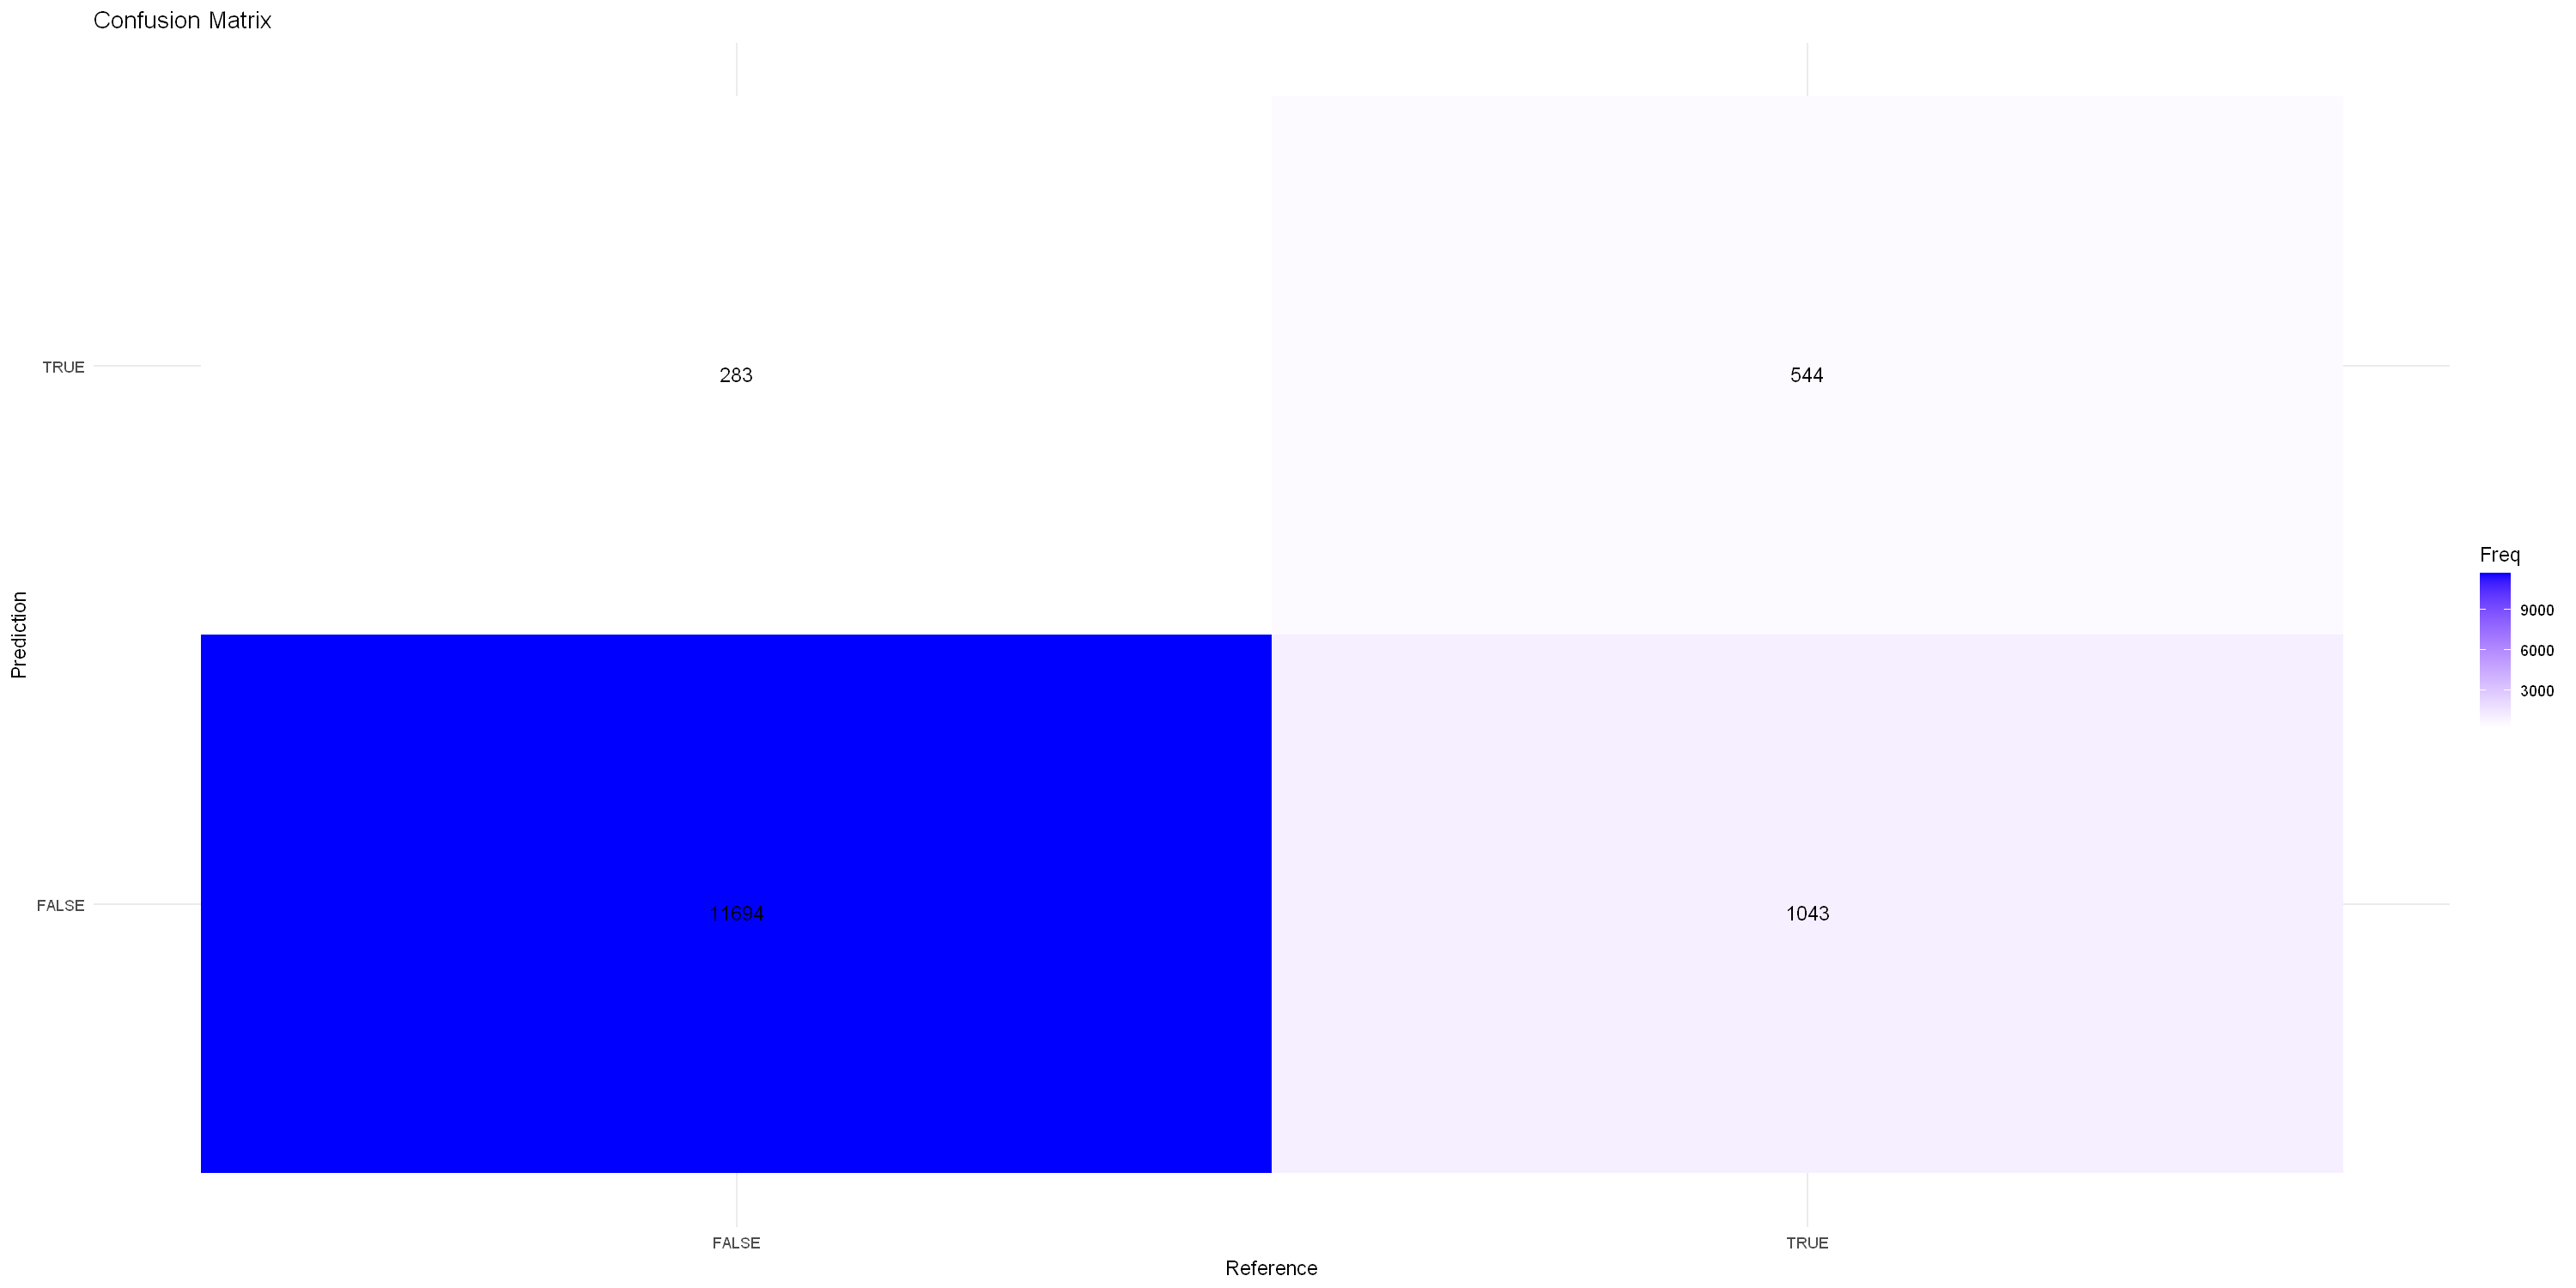

In [362]:
plotConfusionMatrix <- function(conf) {
    return(
        as.data.frame(confusion$table) %>%
        ggplot(aes(x = Reference, y = Prediction, fill = Freq)) +
        geom_tile() +
        geom_text(aes(label = Freq), vjust = 1) +
        scale_fill_gradient(low = "white", high = "blue") +  # Color gradient for cells
        labs(title = "Confusion Matrix",
            x = "Reference",
            y = "Prediction") +
        theme_minimal()
    )
}

conf_matrix_df %>% plotConfusionMatrix()

Parameters : `age`, `job`, `marital`, `education`, `default`, `balance`, `housing`, `loan`, `contact`, `day`, `month`, `duration`, `campaign`, `pdays`, `previous`, `poutcome`

Predicted: `y`

Accuracy: 0.9022

McFadden R2: 0.3369

## Model without variables `age`, `default`, `pdays` and `previous`.

In [363]:
mdl <- glm(y ~ job + marital + education + balance + housing + loan + contact + day + month + duration + campaign + poutcome, 
    family = binomial(logit), data = bank_train)
    
summary_mdl <- summary(mdl)
summary_mdl


Call:
glm(formula = y ~ job + marital + education + balance + housing + 
    loan + contact + day + month + duration + campaign + poutcome, 
    family = binomial(logit), data = bank_train)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -5.331e+00  1.189e-01 -44.853  < 2e-16 ***
jobtechnician      -6.420e-02  7.661e-02  -0.838 0.401969    
jobentrepreneur    -1.203e-01  1.388e-01  -0.867 0.386041    
jobblue-collar     -1.683e-01  8.868e-02  -1.898 0.057715 .  
jobunknown         -2.582e-01  2.735e-01  -0.944 0.345261    
jobretired          4.497e-01  9.954e-02   4.517 6.26e-06 ***
jobadmin.           1.315e-01  8.819e-02   1.491 0.136064    
jobservices        -8.380e-02  1.024e-01  -0.819 0.413004    
jobself-employed   -2.087e-01  1.266e-01  -1.649 0.099249 .  
jobunemployed      -1.105e-01  1.296e-01  -0.853 0.393849    
jobhousemaid       -3.537e-01  1.650e-01  -2.144 0.032015 *  
jobstudent          5.066e-01  1.276e-01   3.971 7

In [364]:
mdl %>% ComputeMcFadden()

[1] 0.3368285

In [365]:
anova_mdl <- as.data.frame(Anova(mdl)) %>% arrange(desc(`Pr(>Chisq)`))
anova_mdl

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
balance,5.803106,1,1.599789e-02
day,9.913406,1,1.640792e-03
education,21.012607,3,1.046434e-04
marital,26.852191,2,1.476117e-06
loan,38.688905,1,4.970263e-10
job,77.838285,11,3.857658e-12
campaign,67.200019,1,2.453118e-16
housing,176.137224,1,3.379642e-40
contact,399.846946,2,1.493960e-87


In [366]:
bank_pred <- predict(mdl, newdata = bank_test, type = "response")
bank_pred <- as.logical(round(bank_pred))
accuracy <- mean(bank_pred == bank_test$y)
accuracy

[1] 0.902315

In [367]:
confusion <- confusionMatrix(data = as.factor(bank_pred), reference = as.factor(bank_test$y))
confusion

Confusion Matrix and Statistics

          Reference
Prediction FALSE  TRUE
     FALSE 11695  1043
     TRUE    282   544
                                          
               Accuracy : 0.9023          
                 95% CI : (0.8972, 0.9073)
    No Information Rate : 0.883           
    P-Value [Acc > NIR] : 3.984e-13       
                                          
                  Kappa : 0.4031          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9765          
            Specificity : 0.3428          
         Pos Pred Value : 0.9181          
         Neg Pred Value : 0.6586          
             Prevalence : 0.8830          
         Detection Rate : 0.8622          
   Detection Prevalence : 0.9391          
      Balanced Accuracy : 0.6596          
                                          
       'Positive' Class : FALSE           
                  

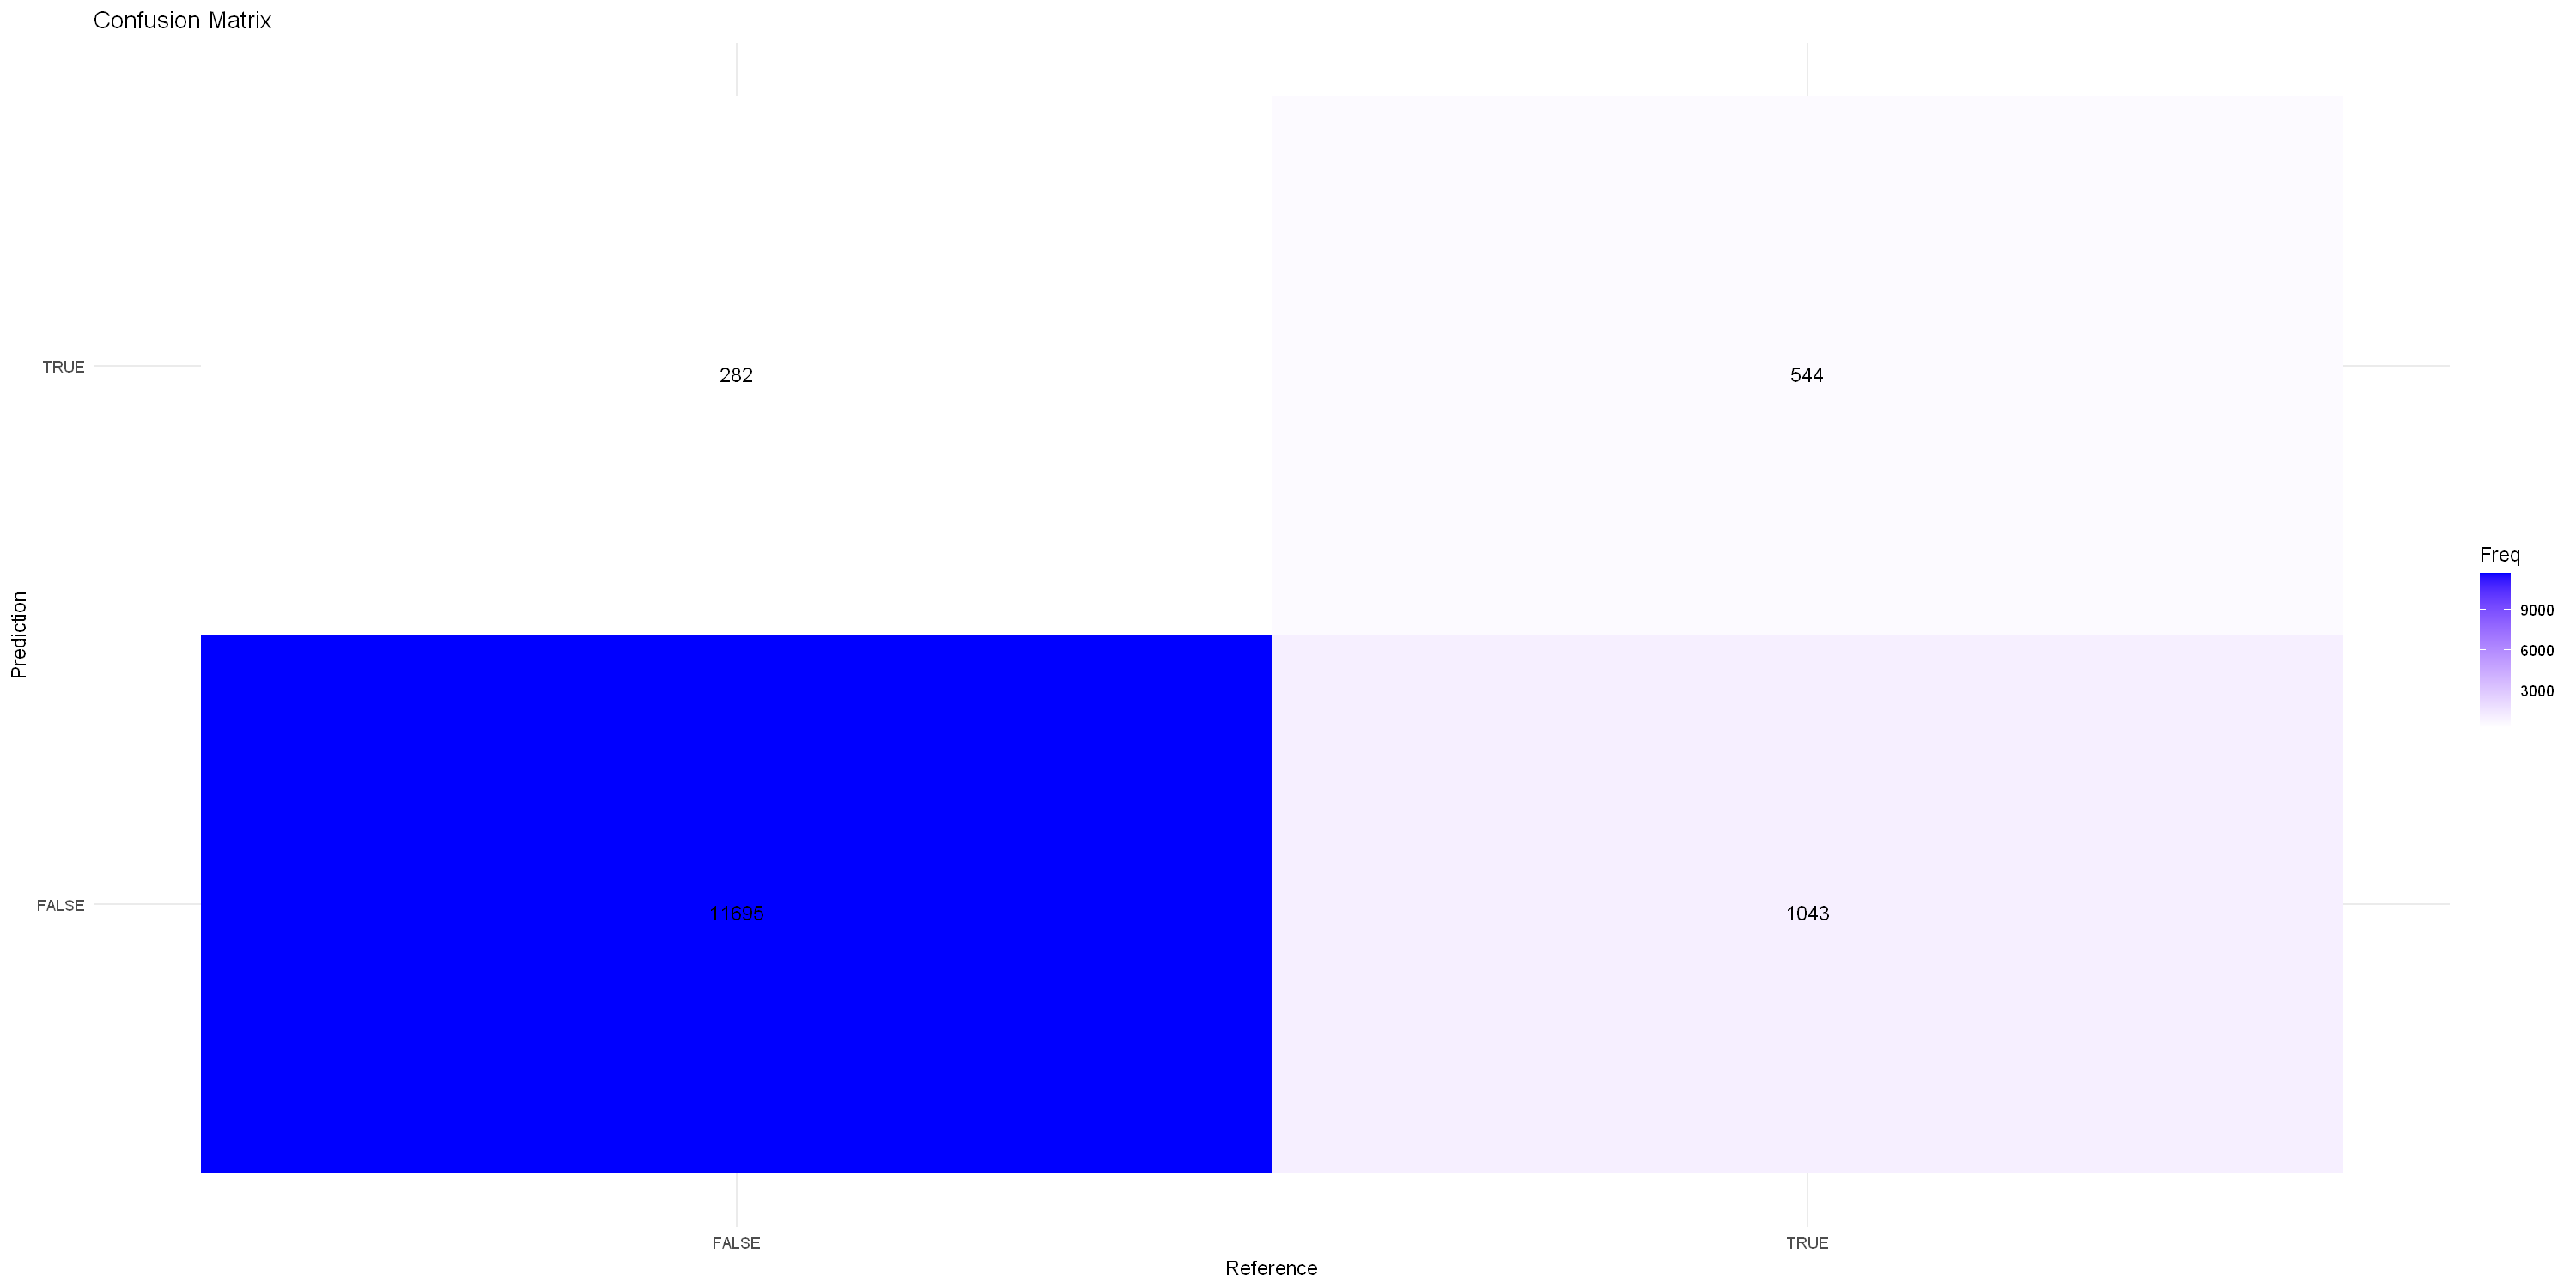

In [368]:
conf_matrix_df %>% plotConfusionMatrix()

Parameters : `job`, `marital`, `education`, `balance`, `housing`, `loan`, `contact`, `day`, `month`, `duration`, `campaign`, `poutcome`

Predicted: `y`

Accuracy: 0.9023

McFadden R2: 0.3368

The removal of variables `age`, `default`, `pdays` and `previous` didn't impact the performance of the model.

## Model with logarithmized numerical variables
This model uses variables that have been logarithmized.

In [369]:
mdl <- glm(y ~ job + marital + education + balance + housing + loan + contact + day_log + month + duration_log + campaign_log + poutcome, 
    family = binomial(logit), data = bank_train)
summary(mdl)


Call:
glm(formula = y ~ job + marital + education + balance + housing + 
    loan + contact + day_log + month + duration_log + campaign_log + 
    poutcome, family = binomial(logit), data = bank_train)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.445e+01  2.534e-01 -57.046  < 2e-16 ***
jobtechnician      -7.234e-02  7.738e-02  -0.935 0.349858    
jobentrepreneur    -1.727e-01  1.388e-01  -1.245 0.213286    
jobblue-collar     -1.897e-01  8.881e-02  -2.136 0.032661 *  
jobunknown         -3.901e-01  2.787e-01  -1.400 0.161650    
jobretired          3.797e-01  1.022e-01   3.715 0.000203 ***
jobadmin.           1.409e-01  8.993e-02   1.567 0.117123    
jobservices        -9.253e-02  1.023e-01  -0.905 0.365534    
jobself-employed   -2.099e-01  1.272e-01  -1.650 0.098856 .  
jobunemployed      -1.724e-01  1.311e-01  -1.315 0.188518    
jobhousemaid       -2.992e-01  1.644e-01  -1.820 0.068775 .  
jobstudent          5.555e-01  1.325e-

In [370]:
mdl %>% ComputeMcFadden()

[1] 0.369888

In [371]:
anova_mdl <- as.data.frame(Anova(mdl)) %>% arrange(desc(`Pr(>Chisq)`))
anova_mdl

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
balance,5.838031,1,1.568337e-02
day_log,7.901530,1,4.939299e-03
education,21.937609,3,6.721030e-05
marital,26.907357,2,1.435958e-06
loan,32.750841,1,1.047610e-08
job,74.955222,11,1.382509e-11
campaign_log,51.474247,1,7.254248e-13
housing,160.972201,1,6.938058e-37
contact,343.063932,2,3.196050e-75


In [372]:
confusion <- confusionMatrix(data = as.factor(bank_pred), reference = as.factor(bank_test$y))
confusion

Confusion Matrix and Statistics

          Reference
Prediction FALSE  TRUE
     FALSE 11695  1043
     TRUE    282   544
                                          
               Accuracy : 0.9023          
                 95% CI : (0.8972, 0.9073)
    No Information Rate : 0.883           
    P-Value [Acc > NIR] : 3.984e-13       
                                          
                  Kappa : 0.4031          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.9765          
            Specificity : 0.3428          
         Pos Pred Value : 0.9181          
         Neg Pred Value : 0.6586          
             Prevalence : 0.8830          
         Detection Rate : 0.8622          
   Detection Prevalence : 0.9391          
      Balanced Accuracy : 0.6596          
                                          
       'Positive' Class : FALSE           
                  

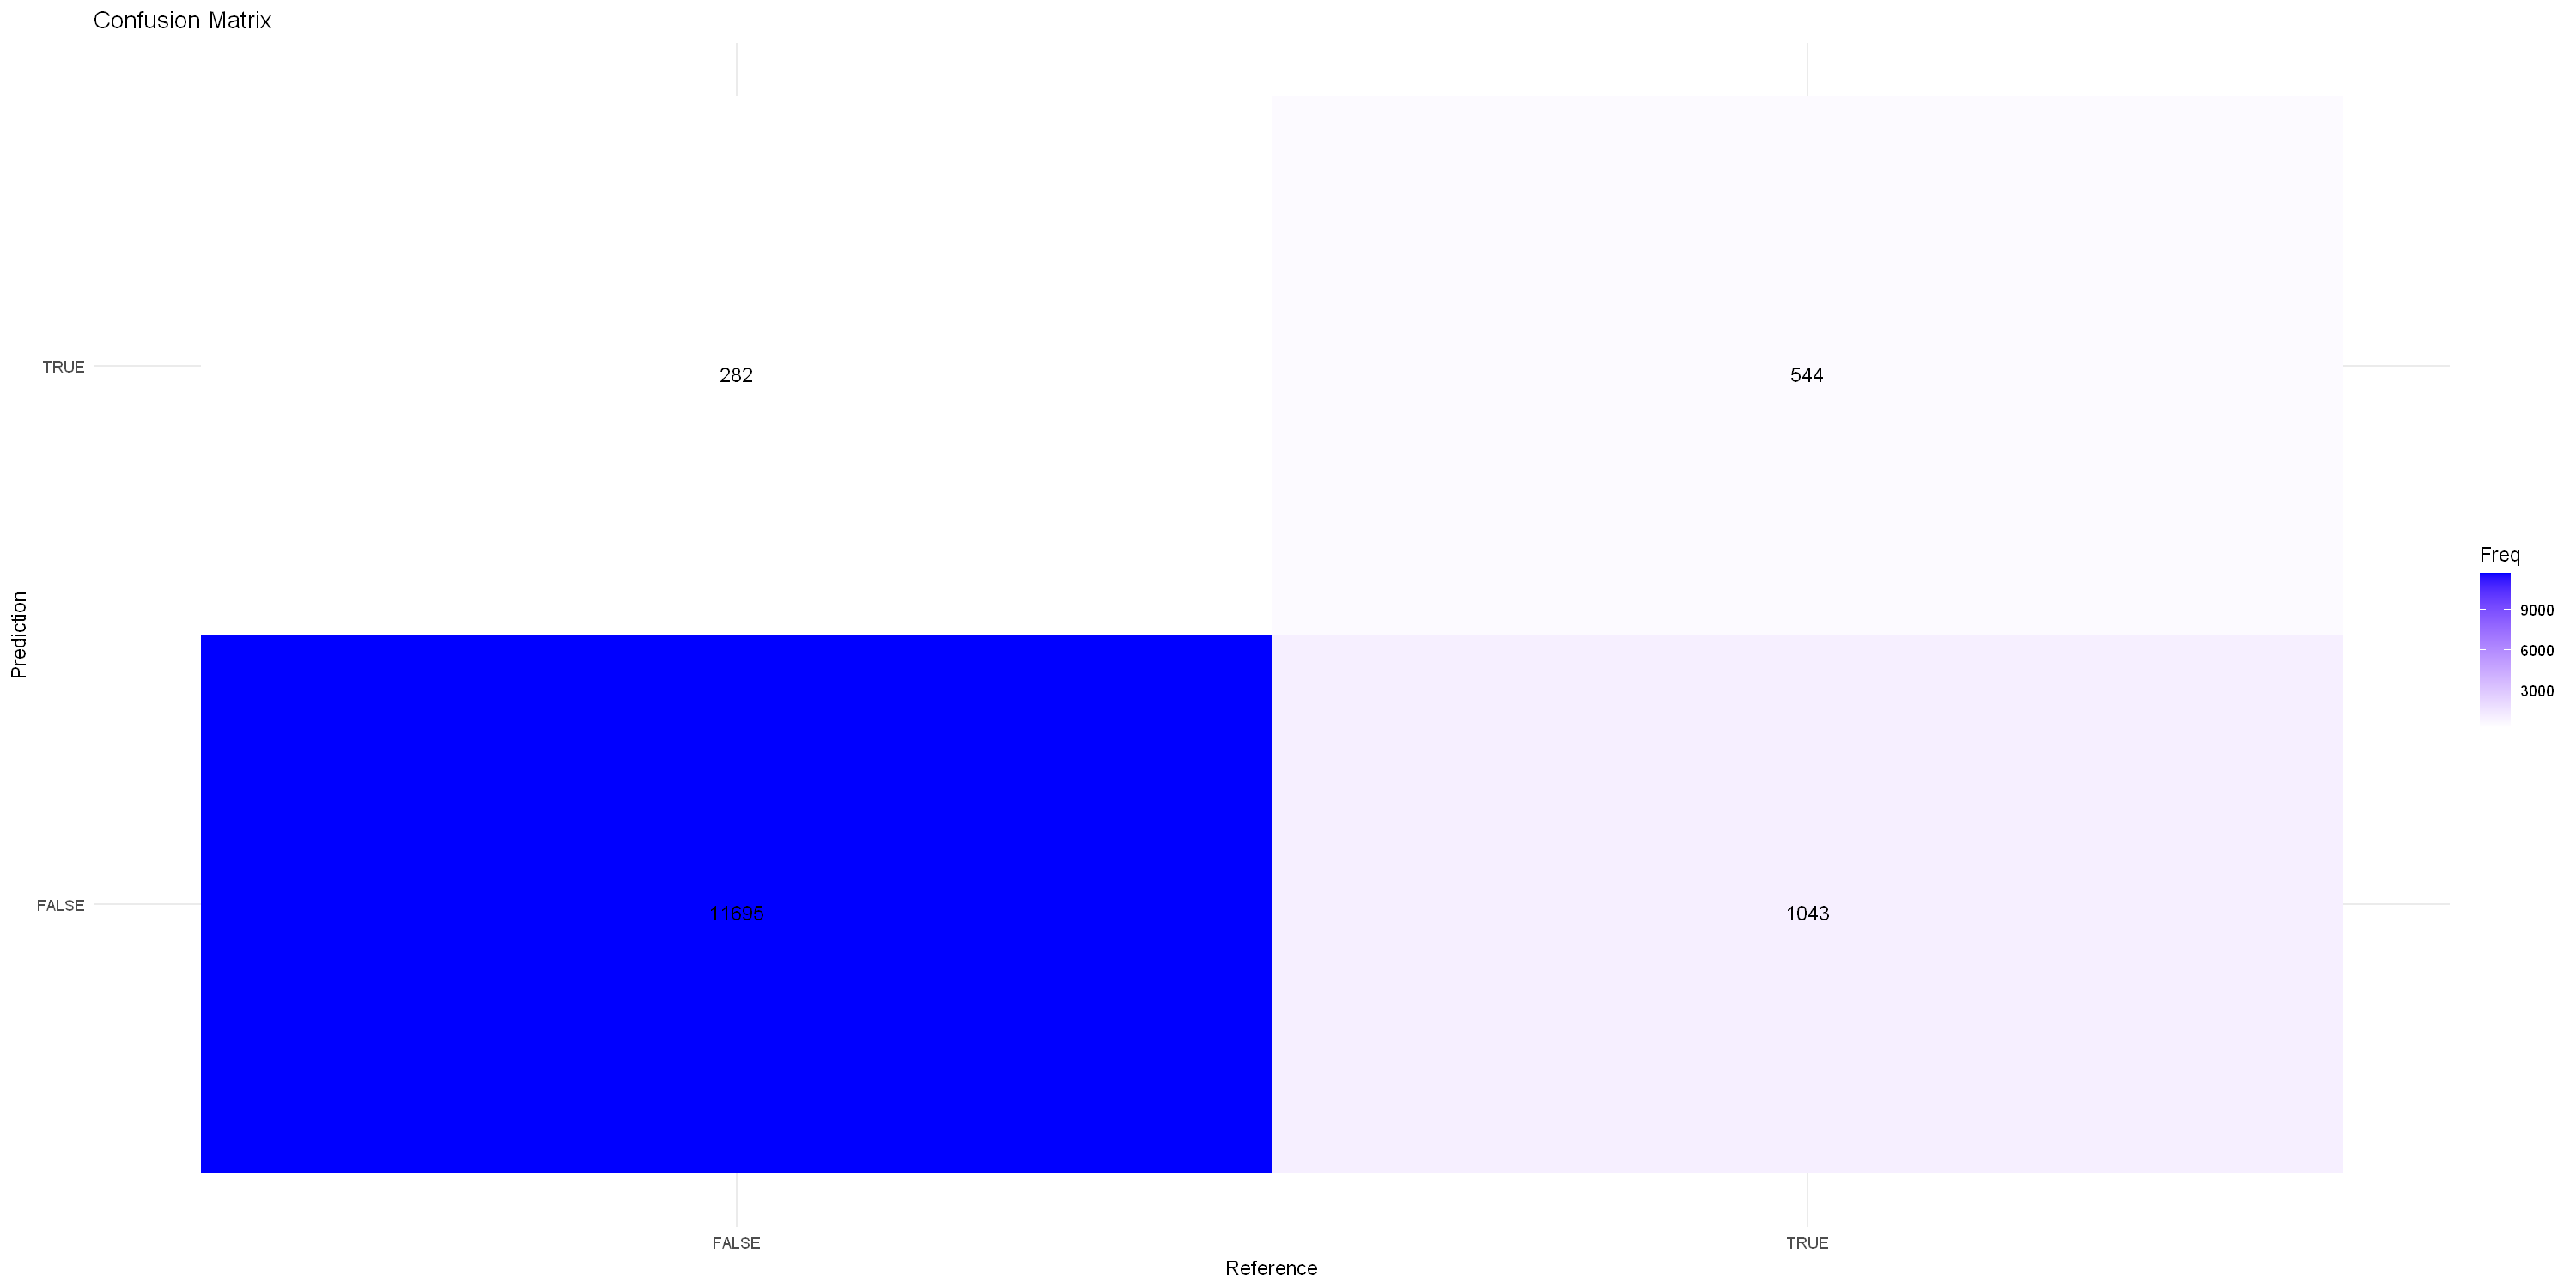

In [373]:
conf_matrix_df %>% plotConfusionMatrix()

Parameters : `job`, `marital`, `education`, `balance`, `housing`, `loan`, `contact`, `day_log`, `month`, `duration_log`, `campaign_log`, `poutcome`

Predicted: `y`

Accuracy: 0.9023

McFadden R2: 0.3699

Applying the `log` function to the numeric variables didn't affect the predictions.